# **Image Caption Generator**


### Import Necessary libraries


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

path_img = '../dataset/Flicker8k_Dataset/'
s_words = stopwords.words('english')


2022-12-01 23:53:24.786993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 23:53:25.208598: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 23:53:26.489022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/darklord/anaconda3/envs/tf/lib/
2022-12-01 23:53:26.489152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

### Extract and clean captions from file


In [4]:
def clean_img(x):
    return str(x).split("#")[0]


In [5]:
df = pd.read_csv('../../../dataset/flickr8k_text/Flickr8k.token.txt',
                 delimiter='\t', names=['image', 'caption'])

df['image'] = df['image'].apply(clean_img)
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40455,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [5]:
def to_dict():
    cap_dict = {}
    for i in range(len(df)):
        img = df.image[i]
        cap = df.caption[i]
        if img not in cap_dict:
            cap_dict[img] = [cap]
        else:
            cap_dict[img].append(cap)
    return cap_dict


In [6]:
def clean_cap(dic):
    ps = PorterStemmer()
    for i in list(dic.keys()):
        corpus = []
        # print(i)
        for j in dic[i]:
            # print(j)
            review = re.sub("[^a-z A-Z]", " ", j)
            review = review.lower()
            review = review.split()
            review = [ps.stem(x) for x in review if len(x) > 1]
            review = " ".join(review)
            corpus.append(review)
        dic[i] = corpus
    return dic


In [7]:
def extract_voc(dic):
    vocab = set()
    for i in list(dic.keys()):
        [vocab.update(j.split()) for j in dic[i]]
    return vocab


In [8]:
from collections import Counter


def extract_vocab(dic):
    vocab = []
    for i in list(dic.keys()):
        vocab.extend(" ".join(dic[i]).split())
    # print(vocab)

    vocab = Counter(vocab)
    # print(vocab)
    return vocab


In [9]:
def save_dic_to_text(dic, path):
    lines = list()
    for img_name, caption_list in dic.items():
        for caption in caption_list:
            lines.append(img_name + '\t' + caption)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()


In [10]:
cap_dict = to_dict()
cap_dict = clean_cap(cap_dict)
vocab = extract_vocab(cap_dict)

save_dic_to_text(cap_dict, 'cleaned_descriptions.txt')


In [11]:
# print(vocab)
df_words = pd.DataFrame(
    {'word': list(vocab.keys()), 'count': list(vocab.values())})
df_words = df_words.sort_values(by='count', ascending=False)
df_words


,word,count
1,in,18987
20,the,18420
36,on,10746
25,dog,10263
4,is,9345
...,...,...
3993,london,1
3992,buss,1
3990,horsemen,1
3988,pring,1


### Plot images with captions


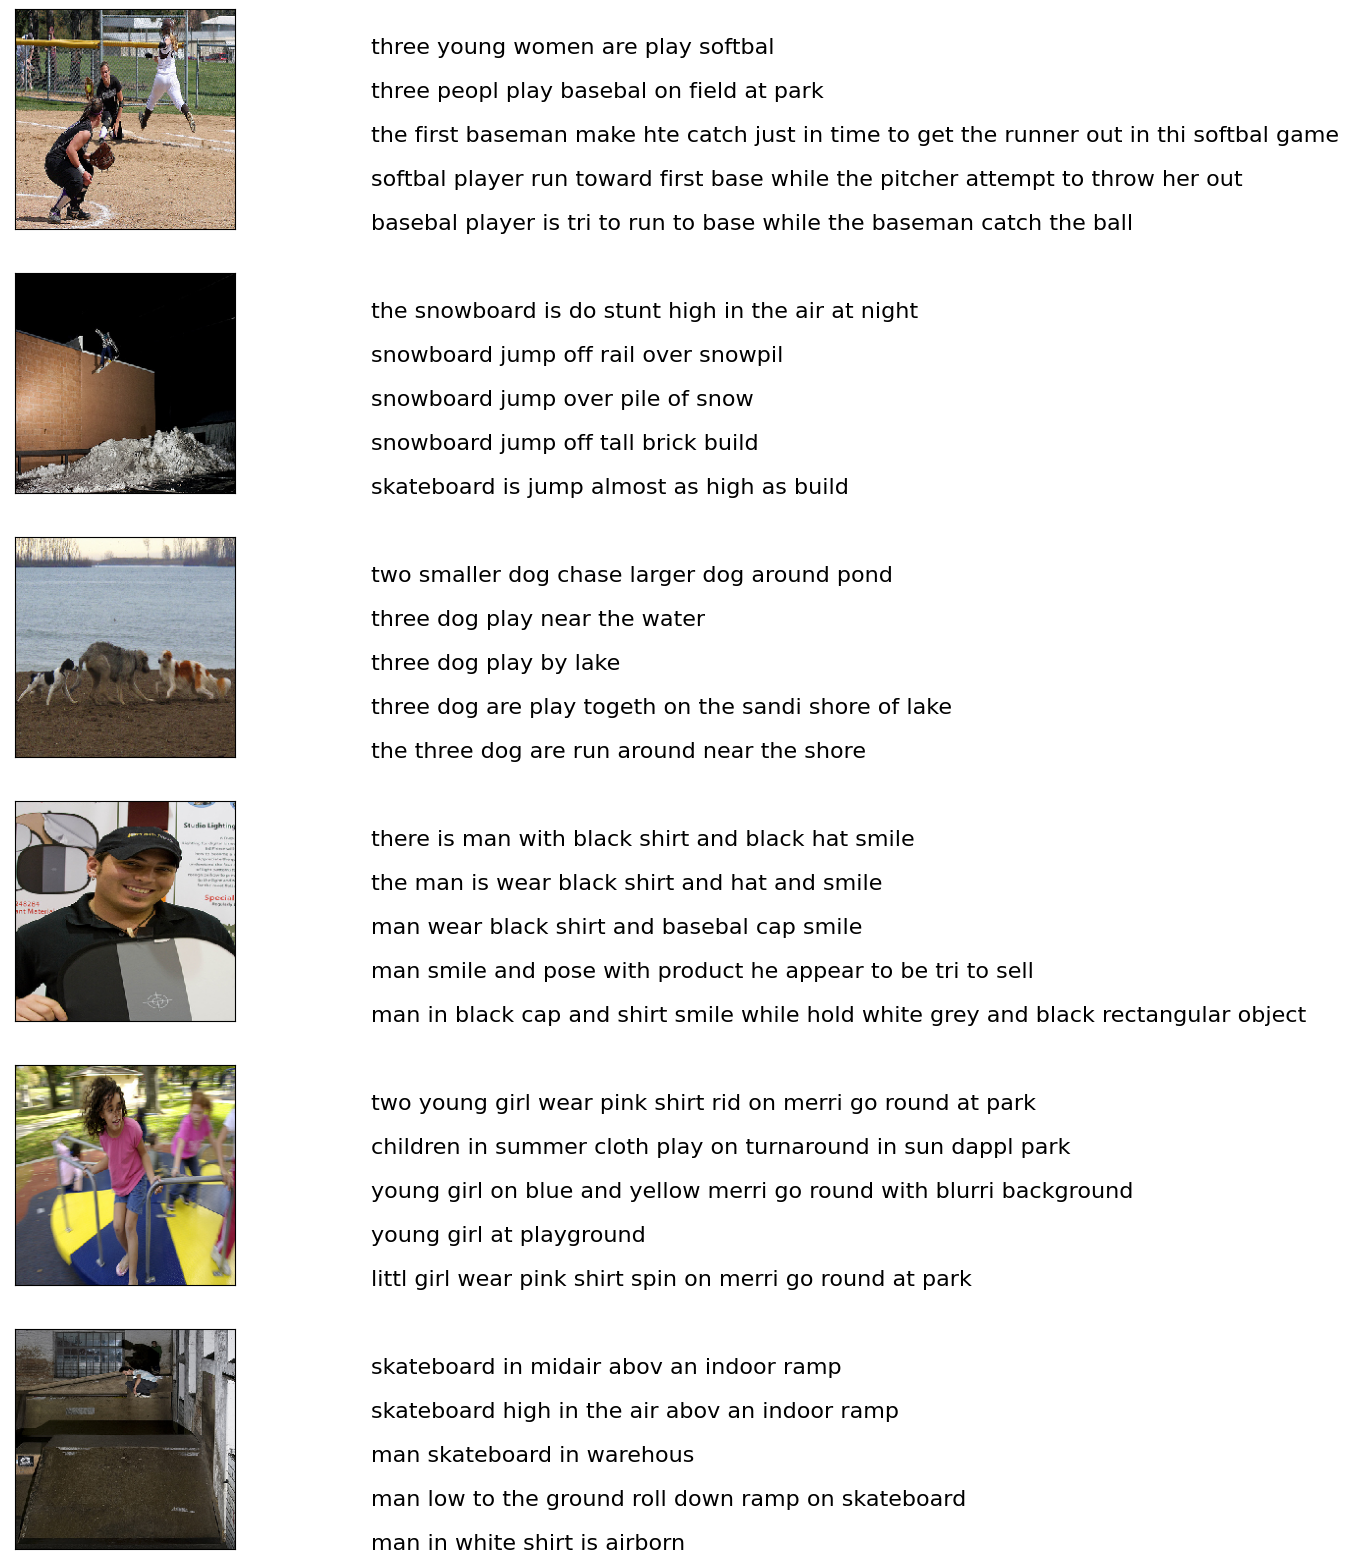

In [12]:
import os
from keras.utils import load_img

target_size = (224, 224, 3)
jpgs = os.listdir(path_img)
fig = plt.figure(figsize=(10, 20))
count = 1

for i in range(6):
    img_name = jpgs[i]
    cap_list = cap_dict[img_name]
    img_name = path_img+'/' + jpgs[i]
    img = load_img(img_name, target_size=target_size)
    ax = fig.add_subplot(6, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1
    ax = fig.add_subplot(6, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_ylim(0, len(cap_list))
    ax.set_xlim(0, 1)
    for i, j in enumerate(cap_list):
        ax.text(0, i, j, fontsize=16)
    count += 1

    # plt.imshow(img)
    # print(cap_list)


### Feature Extraction


There are two ways of processing images seen in the code:

img/255.0img/127.5 - 1
first is to normalize the image, the range is [0, 1], the second is also to normalize the image, the range is [-1, 1]


links:

<!-- https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568 -->

<!-- By performing a spatial convolution an image can be transformed so that the pixel intensity represents the size of the gradient at the pixel location. -->


In [13]:
from tensorflow.keras.applications.xception import Xception


def extract_feature():
    ext_model = Xception(include_top=False, pooling='avg')
    features = {}
    for img_name in jpgs:
        path = path_img+'/'+img_name
        img = Image.open(path)
        img = img.resize((300, 300))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img/127.5 - 1
        feature = ext_model.predict(img, verbose=0)
        features[img_name] = feature
    return features


In [14]:
# features=extract_feature()
# features


2022-11-26 21:42:52.065040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:42:52.092134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:42:52.092417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:42:52.093362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
import joblib

# joblib.dump(features,'features.joblib')


['features.joblib']

In [15]:
import joblib
features = joblib.load('./features.joblib')
features


{'3484842724_ef1124c87a.jpg': array([[0.        , 0.        , 0.        , ..., 0.7352574 , 0.02350297,
         0.03451036]], dtype=float32),
 '3099264059_21653e2536.jpg': array([[0.3402131 , 0.34452003, 0.00932784, ..., 0.14085516, 0.        ,
         0.01100307]], dtype=float32),
 '3492383096_5bbc08f0da.jpg': array([[0.18347555, 0.10057188, 0.15312997, ..., 0.26511183, 0.13086292,
         0.13897063]], dtype=float32),
 '2307118114_c258e3a47e.jpg': array([[0.13897568, 0.        , 0.0169113 , ..., 0.00121881, 0.1284848 ,
         0.17446537]], dtype=float32),
 '2676651833_3bb42bbb32.jpg': array([[0.04179566, 0.00197451, 0.01270884, ..., 0.        , 0.11285119,
         0.01124708]], dtype=float32),
 '3540241710_a4f49cde52.jpg': array([[0.13841754, 0.03672128, 0.13223644, ..., 0.        , 0.        ,
         0.1505758 ]], dtype=float32),
 '1055623002_8195a43714.jpg': array([[0.20614687, 0.02257288, 0.0431717 , ..., 0.        , 0.15341944,
         0.02365885]], dtype=float32),
 '7983

In [16]:
len(features)


8091

### Prepare Train and Test Data


In [19]:
with open('../dataset/flickr8k_text/Flickr_8k.trainImages.txt', 'r') as fl:
    text = fl.read()

train_img_name = text.split('\n')
# with open('../dataset/flickr8k_text/Flickr_8k.testImages.txt', 'r') as fl:
#     text = fl.read()
# test_img_name = text.split('\n')
len(train_img_name)

6000

In [21]:
# train_img_name.index('')


In [26]:
def load_cap(lst):
    count = 0
    dic = {}
    for i in lst:
        l = []
        for j in cap_dict[i]:
            s = '<start>'+j+"<end>"
            l.append(s)
        dic[i] = l
    # print(dic)
    return dic


In [37]:
def load_feature(lst):
    dic = {i: features[i] for i in lst}
    # print(len(dic))
    return dic


In [38]:
# train_feature
train_cap = load_cap(train_img_name)
train_feature = load_feature(train_img_name)


In [41]:
def extract_cap(dic):
    all_cap = []
    for i in dic.keys():
        [all_cap.append(cap) for cap in dic[i]]
    # print(all_cap)
    return all_cap


In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer


def create_token(dic):
    all_cap = extract_cap(dic)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(all_cap)
    return tokenizer


In [43]:
tokenizer = create_token(train_cap)
tokenizer


In [44]:
joblib.dump(tokenizer, 'tokenizer.joblib')


['tokenizer.joblib']

In [45]:
vocab_size = len(tokenizer.word_index)+1
vocab_size


5018

In [46]:
def get_max_len_of_cap(dic):
    all_cap = extract_cap(dic)
    return max(len(d.split()) for d in all_cap)


In [47]:
max_len = get_max_len_of_cap(train_cap)
max_len


33

### Model Building

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


def data_generator(dic, features, tokenizer, max_len, vocab_size, batch_size):
    while True:
        n = 0
        X1, X2, y = [], [], []
        for img_name, cap_list in dic.items():
            feature = features[img_name][0]
            for caption in cap_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                # print('\n*****sequence******\n',sequence)
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    # pad_sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    # to_categorical
                    out_seq = to_categorical(
                        [out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:
                        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                        yield [X1, X2], y
                        n = 0
                        X1, X2, y = [], [], []


In [49]:
def define_model(total_words, max_len):
    input_1= tf.keras.layers.Input(shape=(2048,))
    fe1=tf.keras.layers.Dropout(0.25)(input_1)
    fe2=tf.keras.layers.Dense(256,activation='relu')(fe1)

    input_2=tf.keras.layers.Input(shape=(max_len,))
    se1=tf.keras.layers.Embedding(total_words,1024,mask_zero=True)(input_2)
    se2=tf.keras.layers.Dropout(0.25)(se1)
    se3=tf.keras.layers.LSTM(256,activation='relu')(se2)

    decoder1=tf.keras.layers.concatenate([fe2,se3])
    decoder2=tf.keras.layers.Dense(256,activation='relu')(decoder1)
    outputs=tf.keras.layers.Dense(total_words,activation='softmax')(decoder2)

    model=tf.keras.models.Model(inputs=[input_1,input_2],outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer='adam')
    model.summary()

    return model


In [50]:
model_lstm=define_model(vocab_size,max_len)
epochs=15
batch_size=60

steps=len(train_img_name)// batch_size

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 1024)     5138432     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [51]:
generator=data_generator(train_cap,train_feature,tokenizer,max_len,vocab_size,batch_size)
model_lstm.fit(generator,epochs=epochs,steps_per_epoch=steps,verbose=1)
# print(type(train_cap))


*****sequence******
 [3, 17, 7, 8, 19, 266, 16, 7, 4, 5, 46, 2]

*****sequence******
 [3, 17, 7, 170, 29, 7, 37, 46, 2]

*****sequence******
 [3, 13, 7, 170, 145, 80, 134, 5, 146, 166, 2]

*****sequence******
 [3, 13, 7, 21, 149, 4, 5, 46, 2]

*****sequence******
 [3, 13, 7, 19, 37, 509, 336, 264, 12, 28, 2]

*****sequence******
 [3, 43, 141, 21, 1806, 2]

*****sequence******
 [3, 43, 15, 21, 1806, 94, 24, 433, 2]
Epoch 1/15

*****sequence******
 [3, 5, 48, 8, 21, 3175, 60, 5, 433, 2]

*****sequence******
 [3, 5, 122, 8, 4, 53, 12, 126, 10, 438, 9, 40, 2]

*****sequence******
 [3, 5, 43, 14, 8, 21, 10, 1806, 1978, 9, 40, 224, 5, 126, 2]

*****sequence******
 [3, 29, 7, 4, 5, 46, 117, 172, 747, 91, 4, 54, 66, 2]

*****sequence******
 [3, 29, 7, 4, 5, 46, 42, 91, 86, 2]

*****sequence******
 [3, 29, 7, 8, 42, 91, 36, 4, 5, 46, 2]
  1/100 [..............................] - ETA: 2:48 - loss: 8.5397
*****sequence******
 [3, 7, 8, 105, 172, 91, 4, 54, 66, 39, 38, 37, 5, 46, 2]

*****sequenc

In [52]:
model_lstm.save('model_lstm.h5')

### Prepare Test Set

In [53]:
def test_extract_feature(path,model):
    try:
        img=Image.open(path)
    except:
        print("Incorrect path")
    
    img=img.resize((300,300))
    img=np.array(img)
    if img.shape[2]==4:
        img=img[...,:3]
    img=np.expand_dims(img,axis=0)
    img=img/127.5-1.0
    feature=model.predict(img,verbose=0)
    return feature
    

In [54]:
def test_word_of_id(idx,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==idx:
            return word
    return None

In [83]:
def test_generate_caption(model, tokenizer, feature, max_len):
    in_text='start'
    print(max_len)
    for i in range(max_len):
        print(i)
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen=max_len)
        prediction=model.predict([feature,sequence],verbose=0)
        prediction=np.argmax(prediction)
        word=test_word_of_id(prediction,tokenizer)
        print(word)
        if word is None:
            print("True")
            break
        in_text+=" "+word
        if word=='end':
            break

        # print(in_text)
    return in_text

In [75]:
def test_load_doc(path):
    file=open(path,'r')
    text=file.read()
    file.close()
    return text
    

In [76]:
def text_load_img_name_list(path):
    text=test_load_doc(path)
    img_name_list=text.split('\n')
    return img_name_list


In [77]:
from tensorflow.keras.models import load_model
test_max_len=35
tokenizer=joblib.load('tokenizer.joblib')
model_lstm=load_model('./model_lstm.h5')
xception=Xception(include_top=False,pooling='avg')

In [78]:
with open('../dataset/flickr8k_text/Flickr_8k.testImages.txt', 'r') as fl:
    text = fl.read()
test_img_name = text.split('\n')
len(test_img_name)

1001

In [79]:
test_img_name= test_img_name[:-1]
len(test_img_name)

1000

In [80]:
import random

In [1]:
path_test='../dataset/Flicker8k_Dataset/'

random_test_img_path=path_test+'/'+random.choice(test_img_name)
# print(random_test_img_path)
test_feature=test_extract_feature(random_test_img_path,xception)

print(test_feature.shape)
image=Image.open(random_test_img_path)
caption=test_generate_caption(model_lstm,tokenizer,test_feature,max_len)
print(caption)
plt.imshow(image)



KeyboardInterrupt

